In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import time

In [2]:
import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#Network (use HG's network)
class Policy_net(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy_net, self).__init__()
        
        self.actor_layer = nn.Sequential(
            nn.Linear(state_dim, 400),
            nn.ReLU(),
            nn.Linear(400,300),
            nn.ReLU(),
            nn.Linear(300, action_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.actor_layer(x) 
    
    
class Value_net(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Value_net, self).__init__()
        
        self.critic_layer = nn.Sequential(
            nn.Linear(state_dim+action_dim, 400),
            nn.ReLU(),
            nn.Linear(400,300),
            nn.ReLU(),
            nn.Linear(300, 1)
        )
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.critic_layer(x)    

In [4]:
#Agent
class Agent():
    def __init__(self, state_dim , action_range , seed ):
        
        self.action_range = action_range
        self.action_dim = len(action_range)
        
        self.target_policy_net = Policy_net(state_dim,self.action_dim)
        self.target_value_net = Value_net(state_dim,self.action_dim)
        self.learning_policy_net = Policy_net(state_dim,self.action_dim)
        self.learning_value_net = Value_net(state_dim,self.action_dim)
        
        self.target_policy_net.load_state_dict(self.learning_policy_net.state_dict())
        self.target_value_net.load_state_dict(self.learning_value_net.state_dict())
        
        self.gamma = 0.99
        self.actor_learning_rate = 0.0001
        self.critic_learning_rate = 0.001
        self.batch_size = 64
        self.replay_buffer = []
        self.buffer_size = 100000
        self.buffer_index = 0
        self.seed = seed
        self.target_update = 0.001
        
        
        self.policy_optimizer = optim.Adam(self.learning_policy_net.parameters(), lr=self.actor_learning_rate)
        self.value_optimizer = optim.Adam(self.learning_value_net.parameters(), lr=self.critic_learning_rate)
        self.criterion = nn.MSELoss()
        self.plot_reward = []
        
        self.learning_policy_net.zero_grad()
        self.learning_value_net.zero_grad()
        
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        
        
    def get_target_action(self,x):
        return self.target_policy_net(torch.Tensor(x)).detach()
    
    def get_learning_action(self,x):
        return self.learning_policy_net(torch.Tensor(x))
    
    def get_target_action_value(self,state,action):
        
        return self.target_value_net( torch.Tensor(state),torch.Tensor(action) ).detach()
    
    def get_learning_action_value(self,state,action):
        return self.learning_value_net(torch.Tensor(state),torch.Tensor(action))
    
    def set_decay_optimizer(self):
        self.actor_learning_rate = self.actor_learning_rate*0.999
        self.critic_learning_rate =self.critic_learning_rate*0.999
        self.policy_optimizer = optim.Adam(self.learning_policy_net.parameters(), lr=self.actor_learning_rate)
        self.value_optimizer = optim.Adam(self.learning_value_net.parameters(), lr=self.critic_learning_rate)
 
        
        
    def cal_target_loss(self,batch):
        state_batch = [e[0] for e in batch]
        action_batch = [e[1] for e in batch]
        reward_batch = [[e[2]] for e in batch]
        next_state_batch = [e[3] for e in batch]
        
        
        #target_value = [self.get_target_value(reward_batch[i],next_state_batch[i]) for i in range(self.batch_size)]
        #target_value = torch.stack(target_value).detach()
        target_value = self.get_target_value(reward_batch,next_state_batch)
        
        learning_value = self.get_learning_action_value(state_batch, action_batch)
        
        
        loss = self.criterion(target_value, learning_value)
        '''if(loss > 1000):
            print("##########################target_value#########################")
            print(target_value)

            print("##########################learning_value#########################")
            print(learning_value)'''
        
        
        
        return loss
        
    def target_net_update(self):    
        for t_p_params , l_p_params in zip(self.target_policy_net.parameters() , self.learning_policy_net.parameters()):
            t_p_params.data.copy_( t_p_params.data * (1-self.target_update) + self.target_update * l_p_params.data )
        
        for t_v_params , l_v_params in zip(self.target_value_net.parameters() , self.learning_value_net.parameters()):
            t_v_params.data.copy_( t_v_params.data * (1-self.target_update) + self.target_update * l_v_params.data )
                
        
    def get_target_value(self,reward, next_state):
        action = self.get_target_action(next_state)
        target_action_value = self.get_target_action_value(next_state,action)

        target_value = torch.Tensor(reward) + self.gamma * target_action_value.squeeze(0)
        
        

        return target_value        
    def get_batch(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        return batch

    def set_network_train(self):
        self.learning_policy_net.train()
        self.learning_value_net.train()
        self.target_policy_net.train()
        self.target_value_net.train()        
        
######################################################################3    
    
    def train(self):
        
        self.learning_policy_net.zero_grad()
        self.learning_value_net.zero_grad()       
        self.target_policy_net.zero_grad()
        self.target_value_net.zero_grad()               
        
        self.set_network_train()
        
        batch = self.get_batch()
        
        
        target_loss =self.cal_target_loss(batch)
        target_loss.backward()
        self.value_optimizer.step()
        
        self.learning_value_net.zero_grad()
        
        state_batch = [e[0] for e in batch]
        d_action = self.get_learning_action(state_batch)
        action_value = self.get_learning_action_value(state_batch,d_action)
        
        mean_action_value = -torch.mean(action_value)
        mean_action_value.backward()
        self.policy_optimizer.step()
        
        self.learning_policy_net.zero_grad()
        self.learning_value_net.zero_grad()
        self.target_policy_net.zero_grad()
        self.target_value_net.zero_grad()               
        
        self.target_net_update()
        
        return target_loss , mean_action_value
       
        
    def get_noise_action(self,state, variance):
        mean = self.get_learning_action(state)
        mean = mean.detach().numpy()
        mean = mean.squeeze(0)
        noise_action = []
        for i in range(len(mean)):
            for j in range(10000):
                action = np.random.normal(mean[i], variance , 1).item()
                if(action >= -1 and action <=1):
                    noise_action.append(action)
                    break
            if( len(noise_action) <= i):
                noise_actioin.append(mean[i])
        return noise_action

    
                
        
    def buffer_update(self, replay):
        if(len(self.replay_buffer) < self.buffer_size):
            self.replay_buffer.append(replay)
            self.buffer_index += 1
        else:
            self.replay_buffer[self.buffer_index] = replay
            self.buffer_index += 1
        if(self.buffer_index == self.buffer_size):
            self.buffer_index=0
        
    def set_reward_plot(self, reward_sum):
        self.plot_reward.append(reward_sum)
        
    def set_network_exploration(self):
        self.learning_policy_net.eval()
        self.learning_value_net.eval()
        self.target_policy_net.eval()
        self.target_value_net.eval()
                
        
    def save(self,directory):
        torch.save({'learning_policy_net_state_dict' :  self.learning_policy_net.state_dict() ,'learning_value_net_state_dict' : self.learning_value_net.state_dict() , 'target_policy_net_state_dict' :  self.target_policy_net.state_dict() ,'target_value_net_state_dict' : self.target_value_net.state_dict() } , directory + '/halfcheetah_model_seed_{}.pth'.format(self.seed) )
        
        
    def load(self,file_name):
        checkpoint = torch.load(directory)
        
        self.learning_policy_net.load_state_dict(checkpoint['learning_policy_net_state_dict'])
        self.learning_value_net.load_state_dict(checkpoint['learning_value_net_state_dict'])
        self.target_policy_net.load_state_dict(checkpoint['target_policy_net_state_dict'])
        self.target_value_net.load_state_dict(checkpoint['target_value_net_state_dict'])

In [5]:
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=False)
action_range = []
for min_action, max_action in zip(env.action_space.low,env.action_space.high):
    action_range.append([min_action,max_action])
state_dim = len(env.observation_space.sample())
seed = 0
step = 0

print(action_range)

agent = Agent(state_dim, action_range, seed)
num_iteration = 5000
variance = 0.5
for iteration in range(num_iteration):
    done = False
    reward_sum = 0
    observation = env.reset()
    state = observation
    value_loss_sum = 0
    policy_loss_sum = 0
    for t in range(1000):
        agent.set_network_exploration()

        action = agent.get_noise_action([state],variance)

        obs , reward, done, info = env.step(action)
        episode = (state, action, reward, obs)
        agent.buffer_update(episode)

        step += 1
        if(step > 1000):
            value, policy = agent.train()
            value_loss_sum += value
            policy_loss_sum += policy
        state = obs[:]
        if(done):
            break
    observation = env.reset()
    state = observation
    for t in range(1000):
        agent.set_network_exploration()
        action = agent.get_learning_action([state])
        action = action.squeeze(0)
        obs , reward, done, info = env.step(action.detach().numpy())
        
        reward_sum += reward
        state = obs[:]
        if(done):
            break
    agent.set_reward_plot(reward_sum) 
    variance -= 0.0002
    if(variance < 0.05):
        variance = 0.05
    if(iteration%100 == 0):
        agent.save('./model_halfcheetah')
    print("value loss : {} ".format(value_loss_sum))
    print("policy loss : {} ".format(policy_loss_sum))
    print("reward at itr {} : {}".format(iteration, reward_sum))
    print("step : {}".format(step))
    agent.set_decay_optimizer()



[[-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0]]
value loss : 0 
policy loss : 0 
reward at itr 0 : 118.2469153610966
step : 1000
value loss : 24.371118545532227 
policy loss : -464.1347351074219 
reward at itr 1 : 109.21037720328903
step : 2000
value loss : 22.12196159362793 
policy loss : -1163.6043701171875 
reward at itr 2 : 110.71150708376688
step : 3000
value loss : 33.1196403503418 
policy loss : -2024.109375 
reward at itr 3 : 110.71150515728908
step : 4000
value loss : 49.618919372558594 
policy loss : -3097.450927734375 
reward at itr 4 : 110.7115304430518
step : 5000
value loss : 70.9863052368164 
policy loss : -4195.89111328125 
reward at itr 5 : 134.6801715456911
step : 6000
value loss : 98.0871810913086 
policy loss : -5273.80908203125 
reward at itr 6 : 108.5080880199702
step : 7000
value loss : 118.22705078125 
policy loss : -6140.373046875 
reward at itr 7 : 107.45559268995716
step : 8000
value loss : 137.1378631591797 
policy loss : -6710

value loss : 2012.445068359375 
policy loss : -74078.515625 
reward at itr 73 : 860.2269135646303
step : 74000
value loss : 2136.105224609375 
policy loss : -74867.1796875 
reward at itr 74 : 414.59127366813453
step : 75000
value loss : 2111.532470703125 
policy loss : -75418.8359375 
reward at itr 75 : 545.809042338288
step : 76000
value loss : 2201.36572265625 
policy loss : -76276.8828125 
reward at itr 76 : 874.1602438908818
step : 77000
value loss : 2284.738037109375 
policy loss : -76964.59375 
reward at itr 77 : 474.3946339443293
step : 78000
value loss : 2357.850341796875 
policy loss : -77909.6640625 
reward at itr 78 : 918.897921339203
step : 79000
value loss : 2414.09619140625 
policy loss : -78964.7578125 
reward at itr 79 : 743.3827543006556
step : 80000
value loss : 2449.8349609375 
policy loss : -79744.0234375 
reward at itr 80 : 700.6022425800795
step : 81000
value loss : 2624.033447265625 
policy loss : -80501.9453125 
reward at itr 81 : 292.13349372639954
step : 82000

value loss : 4098.9345703125 
policy loss : -144353.640625 
reward at itr 146 : 701.1416564219561
step : 147000
value loss : 4065.30859375 
policy loss : -145722.140625 
reward at itr 147 : 1471.2002803654188
step : 148000
value loss : 4111.58447265625 
policy loss : -146820.984375 
reward at itr 148 : 1697.4402951335924
step : 149000
value loss : 4151.783203125 
policy loss : -147979.453125 
reward at itr 149 : 1785.6860860736788
step : 150000
value loss : 4182.0537109375 
policy loss : -149004.421875 
reward at itr 150 : 1300.1056423576579
step : 151000
value loss : 4127.2607421875 
policy loss : -150161.671875 
reward at itr 151 : 1579.2202814587342
step : 152000
value loss : 4252.4091796875 
policy loss : -151694.203125 
reward at itr 152 : 1057.0830601003447
step : 153000
value loss : 4212.39794921875 
policy loss : -153206.734375 
reward at itr 153 : 1352.43574036488
step : 154000
value loss : 4265.8212890625 
policy loss : -154164.984375 
reward at itr 154 : 1707.9688518735254
s

value loss : 5547.51708984375 
policy loss : -217953.875 
reward at itr 220 : 2213.185426793873
step : 221000
value loss : 5715.11572265625 
policy loss : -218932.125 
reward at itr 221 : 1423.5497026075254
step : 222000
value loss : 5695.2412109375 
policy loss : -220047.6875 
reward at itr 222 : 2558.6762888012577
step : 223000
value loss : 5745.662109375 
policy loss : -220917.375 
reward at itr 223 : 1059.580636334099
step : 224000
value loss : 5698.41552734375 
policy loss : -221974.15625 
reward at itr 224 : 228.14633374037277
step : 225000
value loss : 5757.21826171875 
policy loss : -222993.1875 
reward at itr 225 : 205.78188211269187
step : 226000
value loss : 5621.330078125 
policy loss : -223938.09375 
reward at itr 226 : 1021.6415827310411
step : 227000
value loss : 5828.2734375 
policy loss : -224677.546875 
reward at itr 227 : 577.9370511908764
step : 228000
value loss : 5653.86279296875 
policy loss : -225790.5625 
reward at itr 228 : 1102.1917759320108
step : 229000
val

value loss : 7008.861328125 
policy loss : -293296.75 
reward at itr 294 : 2023.7943600480583
step : 295000
value loss : 6960.55517578125 
policy loss : -294355.5625 
reward at itr 295 : 2418.797206933632
step : 296000
value loss : 7116.16650390625 
policy loss : -295605.0625 
reward at itr 296 : 1947.602839381589
step : 297000
value loss : 7073.0048828125 
policy loss : -296458.46875 
reward at itr 297 : 1967.4968833608652
step : 298000
value loss : 7083.8193359375 
policy loss : -297295.71875 
reward at itr 298 : 650.3006028358906
step : 299000
value loss : 7355.8974609375 
policy loss : -298317.75 
reward at itr 299 : 1996.9691511320195
step : 300000
value loss : 7557.904296875 
policy loss : -299138.1875 
reward at itr 300 : 2071.486982835843
step : 301000
value loss : 7165.5244140625 
policy loss : -300093.53125 
reward at itr 301 : 2357.9444293674906
step : 302000
value loss : 7390.330078125 
policy loss : -301476.53125 
reward at itr 302 : 2104.263454864592
step : 303000
value l

value loss : 8607.6259765625 
policy loss : -362723.375 
reward at itr 369 : 1461.1464163670973
step : 370000
value loss : 8715.201171875 
policy loss : -363493.78125 
reward at itr 370 : 1876.0739056774066
step : 371000
value loss : 8571.8564453125 
policy loss : -364361.09375 
reward at itr 371 : 1470.5573294985982
step : 372000
value loss : 8771.97265625 
policy loss : -364962.40625 
reward at itr 372 : 1477.2894562776648
step : 373000
value loss : 8884.75390625 
policy loss : -365636.0 
reward at itr 373 : 1548.9560231864716
step : 374000
value loss : 8839.1357421875 
policy loss : -366450.3125 
reward at itr 374 : 1743.349993154501
step : 375000
value loss : 8898.533203125 
policy loss : -367130.15625 
reward at itr 375 : 1920.378411125801
step : 376000
value loss : 8803.6376953125 
policy loss : -367979.625 
reward at itr 376 : 2039.6515623435373
step : 377000
value loss : 8923.435546875 
policy loss : -368650.46875 
reward at itr 377 : 1581.4341389856475
step : 378000
value loss

value loss : 8908.705078125 
policy loss : -409821.59375 
reward at itr 444 : 2566.1702755474953
step : 445000
value loss : 9356.4384765625 
policy loss : -409652.6875 
reward at itr 445 : 2169.7308432551786
step : 446000
value loss : 9299.42578125 
policy loss : -410290.375 
reward at itr 446 : 2192.427996086179
step : 447000
value loss : 9308.7490234375 
policy loss : -411181.4375 
reward at itr 447 : 2052.4795297533688
step : 448000
value loss : 9101.529296875 
policy loss : -411643.46875 
reward at itr 448 : 2409.494970111112
step : 449000
value loss : 9485.1337890625 
policy loss : -412235.90625 
reward at itr 449 : 152.03572852812653
step : 450000
value loss : 9280.9462890625 
policy loss : -412867.46875 
reward at itr 450 : 183.9466077561893
step : 451000
value loss : 9295.7060546875 
policy loss : -413444.25 
reward at itr 451 : 2322.4825748197954
step : 452000
value loss : 9522.4892578125 
policy loss : -413646.0 
reward at itr 452 : 2299.5382810232873
step : 453000
value loss

value loss : 9077.2900390625 
policy loss : -443838.6875 
reward at itr 519 : 1868.157157233166
step : 520000
value loss : 9048.7412109375 
policy loss : -444358.6875 
reward at itr 520 : 890.8973665466953
step : 521000
value loss : 8385.3740234375 
policy loss : -444894.1875 
reward at itr 521 : 438.2885415275408
step : 522000
value loss : 8431.203125 
policy loss : -445032.9375 
reward at itr 522 : 2156.0145725698703
step : 523000
value loss : 8723.23828125 
policy loss : -445166.3125 
reward at itr 523 : 1591.8271062547756
step : 524000
value loss : 8846.1904296875 
policy loss : -445552.125 
reward at itr 524 : 2453.9390316613644
step : 525000
value loss : 8549.015625 
policy loss : -445998.6875 
reward at itr 525 : 1270.8734852632015
step : 526000
value loss : 8615.1533203125 
policy loss : -445966.15625 
reward at itr 526 : 2202.6512153993135
step : 527000
value loss : 8949.41796875 
policy loss : -445943.84375 
reward at itr 527 : 2043.1100913233402
step : 528000
value loss : 90

value loss : 11049.78125 
policy loss : -457309.40625 
reward at itr 594 : 3502.162248091807
step : 595000
value loss : 10775.0322265625 
policy loss : -457611.15625 
reward at itr 595 : 69.62658277065468
step : 596000
value loss : 11215.1650390625 
policy loss : -457307.3125 
reward at itr 596 : 2373.4955773821193
step : 597000
value loss : 10920.013671875 
policy loss : -457252.875 
reward at itr 597 : 2267.8901002194157
step : 598000
value loss : 10818.5634765625 
policy loss : -457180.59375 
reward at itr 598 : 2507.490122136815
step : 599000
value loss : 10676.37109375 
policy loss : -457603.625 
reward at itr 599 : 2477.6661215498693
step : 600000
value loss : 10931.4921875 
policy loss : -457891.875 
reward at itr 600 : 3769.6478174339227
step : 601000
value loss : 10600.1279296875 
policy loss : -458176.0625 
reward at itr 601 : 1542.9061647572873
step : 602000
value loss : 10455.638671875 
policy loss : -458013.96875 
reward at itr 602 : 2611.3214230991434
step : 603000
value 

value loss : 10859.7607421875 
policy loss : -473394.5 
reward at itr 669 : 3213.0289703533376
step : 670000
value loss : 10819.7333984375 
policy loss : -473518.0 
reward at itr 670 : 3083.0447399206273
step : 671000
value loss : 10573.0751953125 
policy loss : -474259.15625 
reward at itr 671 : 2200.9417620245003
step : 672000
value loss : 10747.9150390625 
policy loss : -474145.6875 
reward at itr 672 : 2569.5788015920516
step : 673000
value loss : 10794.7626953125 
policy loss : -474412.4375 
reward at itr 673 : 2775.431430111847
step : 674000
value loss : 10439.8115234375 
policy loss : -475116.625 
reward at itr 674 : 3365.949483818841
step : 675000
value loss : 10481.146484375 
policy loss : -475063.5 
reward at itr 675 : 3198.119417787082
step : 676000
value loss : 10269.21875 
policy loss : -475178.375 
reward at itr 676 : 1039.8502193625031
step : 677000
value loss : 10585.740234375 
policy loss : -475347.8125 
reward at itr 677 : 3375.7763017326583
step : 678000
value loss :

value loss : 9665.1669921875 
policy loss : -484712.6875 
reward at itr 744 : 2737.1874449631373
step : 745000
value loss : 9902.5947265625 
policy loss : -484923.75 
reward at itr 745 : 2717.694710865287
step : 746000
value loss : 10234.615234375 
policy loss : -484992.28125 
reward at itr 746 : 1997.323474879643
step : 747000
value loss : 9836.1279296875 
policy loss : -485080.65625 
reward at itr 747 : 1890.1924346948163
step : 748000
value loss : 10036.5869140625 
policy loss : -484426.03125 
reward at itr 748 : 2674.2955876493647
step : 749000
value loss : 10284.9921875 
policy loss : -485164.125 
reward at itr 749 : 1905.0359170471033
step : 750000
value loss : 10048.6279296875 
policy loss : -484891.09375 
reward at itr 750 : 2859.870421964149
step : 751000
value loss : 9764.0380859375 
policy loss : -484624.21875 
reward at itr 751 : 1884.4610050100794
step : 752000
value loss : 9774.7626953125 
policy loss : -484495.5 
reward at itr 752 : 2394.0065304075256
step : 753000
value

value loss : 10422.5283203125 
policy loss : -502477.6875 
reward at itr 819 : 871.8252332223465
step : 820000
value loss : 10528.365234375 
policy loss : -503027.78125 
reward at itr 820 : 2935.843519977438
step : 821000
value loss : 10722.2998046875 
policy loss : -502435.34375 
reward at itr 821 : 1889.7353329312248
step : 822000
value loss : 10629.962890625 
policy loss : -502562.875 
reward at itr 822 : 1683.0861183279847
step : 823000
value loss : 10902.01953125 
policy loss : -502740.75 
reward at itr 823 : 1871.361884164918
step : 824000
value loss : 11480.1572265625 
policy loss : -502779.9375 
reward at itr 824 : 2134.0038648104432
step : 825000
value loss : 10879.3740234375 
policy loss : -503312.3125 
reward at itr 825 : 2219.8221414495683
step : 826000
value loss : 11213.8525390625 
policy loss : -504503.125 
reward at itr 826 : 2998.341968818545
step : 827000
value loss : 11076.9755859375 
policy loss : -505047.46875 
reward at itr 827 : 2560.3472044285763
step : 828000
v

value loss : 12450.4375 
policy loss : -508461.96875 
reward at itr 894 : 531.7470663121776
step : 895000
value loss : 12371.8544921875 
policy loss : -508281.1875 
reward at itr 895 : 2682.7674754353257
step : 896000
value loss : 12289.7021484375 
policy loss : -508553.25 
reward at itr 896 : 2429.5833431347073
step : 897000
value loss : 12405.142578125 
policy loss : -509086.71875 
reward at itr 897 : 3705.0304450804642
step : 898000
value loss : 12015.8916015625 
policy loss : -509250.78125 
reward at itr 898 : 3842.5711608820243
step : 899000
value loss : 12253.43359375 
policy loss : -509074.78125 
reward at itr 899 : 2757.7323977602114
step : 900000
value loss : 12601.677734375 
policy loss : -508978.71875 
reward at itr 900 : 2656.814933373678
step : 901000
value loss : 12336.1640625 
policy loss : -508950.46875 
reward at itr 901 : 2739.604889598377
step : 902000
value loss : 11836.7978515625 
policy loss : -509101.25 
reward at itr 902 : 2506.5212569757687
step : 903000
value 

value loss : 11021.6298828125 
policy loss : -524708.75 
reward at itr 969 : 2058.4110779589196
step : 970000
value loss : 10858.806640625 
policy loss : -524576.6875 
reward at itr 970 : 2814.9819249616535
step : 971000
value loss : 11591.3115234375 
policy loss : -524842.5 
reward at itr 971 : 2704.757812501615
step : 972000
value loss : 11280.9306640625 
policy loss : -524950.6875 
reward at itr 972 : 3007.8831062002955
step : 973000
value loss : 10966.8115234375 
policy loss : -525407.0 
reward at itr 973 : 2764.433732158736
step : 974000
value loss : 11757.0322265625 
policy loss : -524896.8125 
reward at itr 974 : 2899.2816007672845
step : 975000
value loss : 11015.33984375 
policy loss : -524736.8125 
reward at itr 975 : 1581.3652254322865
step : 976000
value loss : 11464.16796875 
policy loss : -525202.9375 
reward at itr 976 : 664.4709700837309
step : 977000
value loss : 11006.392578125 
policy loss : -525487.5625 
reward at itr 977 : 2025.0541941269848
step : 978000
value los

value loss : 11704.6552734375 
policy loss : -517723.8125 
reward at itr 1043 : 1400.3995757765415
step : 1044000
value loss : 11844.5283203125 
policy loss : -517816.3125 
reward at itr 1044 : 2365.560298127694
step : 1045000
value loss : 12028.3544921875 
policy loss : -516980.46875 
reward at itr 1045 : 1134.8560641398487
step : 1046000
value loss : 12806.1259765625 
policy loss : -516666.78125 
reward at itr 1046 : 2293.3577249462915
step : 1047000
value loss : 12382.8896484375 
policy loss : -515357.8125 
reward at itr 1047 : 1923.9876840465197
step : 1048000
value loss : 12895.447265625 
policy loss : -514912.375 
reward at itr 1048 : 3727.7786609380287
step : 1049000
value loss : 13505.6962890625 
policy loss : -514514.78125 
reward at itr 1049 : 2903.6741306082226
step : 1050000
value loss : 13420.8525390625 
policy loss : -514568.75 
reward at itr 1050 : 1541.8683668760723
step : 1051000
value loss : 12712.2705078125 
policy loss : -514005.34375 
reward at itr 1051 : 2083.2306

value loss : 13239.09375 
policy loss : -513604.6875 
reward at itr 1116 : 3262.2326016888746
step : 1117000
value loss : 13479.9140625 
policy loss : -513502.21875 
reward at itr 1117 : 4101.734848785187
step : 1118000
value loss : 13572.6025390625 
policy loss : -512776.8125 
reward at itr 1118 : 2828.289392105019
step : 1119000
value loss : 12992.1064453125 
policy loss : -512113.8125 
reward at itr 1119 : 3029.867555652404
step : 1120000
value loss : 13438.4697265625 
policy loss : -512332.59375 
reward at itr 1120 : 2648.928783750997
step : 1121000
value loss : 14004.6708984375 
policy loss : -511627.0 
reward at itr 1121 : 2805.7432355529854
step : 1122000
value loss : 14122.78515625 
policy loss : -511941.5625 
reward at itr 1122 : 4220.3001991333085
step : 1123000
value loss : 13623.029296875 
policy loss : -513142.34375 
reward at itr 1123 : 2584.2002539505215
step : 1124000
value loss : 13657.5556640625 
policy loss : -514118.09375 
reward at itr 1124 : 3265.254845545902
step

value loss : 12648.283203125 
policy loss : -536933.4375 
reward at itr 1190 : 3954.7760906780504
step : 1191000
value loss : 12408.4541015625 
policy loss : -536626.625 
reward at itr 1191 : 3371.161772508791
step : 1192000
value loss : 12367.7646484375 
policy loss : -536650.8125 
reward at itr 1192 : 3613.542424027593
step : 1193000
value loss : 11977.1318359375 
policy loss : -536862.9375 
reward at itr 1193 : 3425.2048404283905
step : 1194000
value loss : 12422.453125 
policy loss : -537116.4375 
reward at itr 1194 : 3343.0360637581375
step : 1195000
value loss : 11870.7822265625 
policy loss : -536847.9375 
reward at itr 1195 : 3345.070150720066
step : 1196000
value loss : 12338.57421875 
policy loss : -536712.6875 
reward at itr 1196 : 3748.498351170384
step : 1197000
value loss : 12684.9921875 
policy loss : -537178.0 
reward at itr 1197 : 4091.6897376600928
step : 1198000
value loss : 11961.392578125 
policy loss : -536847.1875 
reward at itr 1198 : 3202.405069362311
step : 11

value loss : 10903.845703125 
policy loss : -532054.125 
reward at itr 1264 : 789.9321236022897
step : 1265000
value loss : 10903.5771484375 
policy loss : -531831.0 
reward at itr 1265 : 431.33294441262757
step : 1266000
value loss : 11038.3125 
policy loss : -530947.6875 
reward at itr 1266 : -23.085639768510752
step : 1267000
value loss : 11153.2880859375 
policy loss : -529789.0 
reward at itr 1267 : 453.1465148252615
step : 1268000
value loss : 10438.8046875 
policy loss : -530257.125 
reward at itr 1268 : 1118.1983639817815
step : 1269000
value loss : 10420.91015625 
policy loss : -530017.4375 
reward at itr 1269 : 1124.471944954365
step : 1270000
value loss : 10358.380859375 
policy loss : -529423.375 
reward at itr 1270 : -2.524237406368748
step : 1271000
value loss : 10648.611328125 
policy loss : -528203.1875 
reward at itr 1271 : 38.14384871095448
step : 1272000
value loss : 10509.1728515625 
policy loss : -527565.625 
reward at itr 1272 : 1449.0539353306408
step : 1273000
v

value loss : 10874.2783203125 
policy loss : -523852.59375 
reward at itr 1338 : 2359.45578976446
step : 1339000
value loss : 10654.716796875 
policy loss : -523134.3125 
reward at itr 1339 : 2647.338577319537
step : 1340000
value loss : 10820.1572265625 
policy loss : -522966.71875 
reward at itr 1340 : 2056.1726963742644
step : 1341000
value loss : 10990.39453125 
policy loss : -522894.40625 
reward at itr 1341 : 3247.434666539785
step : 1342000
value loss : 10457.5224609375 
policy loss : -524103.40625 
reward at itr 1342 : 3399.783038225877
step : 1343000
value loss : 10849.82421875 
policy loss : -525503.8125 
reward at itr 1343 : 2720.627921850073
step : 1344000
value loss : 11154.29296875 
policy loss : -526475.9375 
reward at itr 1344 : 4181.518415847483
step : 1345000
value loss : 10940.7197265625 
policy loss : -525983.0625 
reward at itr 1345 : 2675.626003638776
step : 1346000
value loss : 11176.4873046875 
policy loss : -526481.9375 
reward at itr 1346 : 2981.0894799944667


value loss : 12330.685546875 
policy loss : -539749.0 
reward at itr 1412 : 3433.702134837237
step : 1413000
value loss : 12379.6533203125 
policy loss : -538992.5625 
reward at itr 1413 : 3385.0327170015325
step : 1414000
value loss : 11813.5244140625 
policy loss : -539589.625 
reward at itr 1414 : 2340.914078576187
step : 1415000
value loss : 11924.494140625 
policy loss : -539783.1875 
reward at itr 1415 : 4016.2634186686682
step : 1416000
value loss : 12088.1806640625 
policy loss : -539102.875 
reward at itr 1416 : 2556.337628093594
step : 1417000
value loss : 11613.69921875 
policy loss : -539132.5 
reward at itr 1417 : 3791.9762195648
step : 1418000
value loss : 12161.9228515625 
policy loss : -538945.25 
reward at itr 1418 : 2264.9242932326406
step : 1419000
value loss : 12151.1484375 
policy loss : -538608.625 
reward at itr 1419 : 3135.047740448861
step : 1420000
value loss : 12046.6767578125 
policy loss : -537905.125 
reward at itr 1420 : 2968.3362594029395
step : 1421000


value loss : 13458.6171875 
policy loss : -547121.75 
reward at itr 1486 : 3339.171780153174
step : 1487000
value loss : 13784.2626953125 
policy loss : -546565.25 
reward at itr 1487 : 191.90582637578763
step : 1488000
value loss : 13996.626953125 
policy loss : -545990.3125 
reward at itr 1488 : 3222.653162318211
step : 1489000
value loss : 13919.94140625 
policy loss : -545722.5 
reward at itr 1489 : 4069.068720176937
step : 1490000
value loss : 13600.173828125 
policy loss : -545513.4375 
reward at itr 1490 : 201.26321978740782
step : 1491000
value loss : 14049.6689453125 
policy loss : -545608.8125 
reward at itr 1491 : 166.5907112746886
step : 1492000
value loss : 14945.4833984375 
policy loss : -545870.1875 
reward at itr 1492 : 3886.91308705259
step : 1493000
value loss : 14471.953125 
policy loss : -545989.125 
reward at itr 1493 : 3910.1088755493856
step : 1494000
value loss : 14734.337890625 
policy loss : -545079.8125 
reward at itr 1494 : 3149.005514241997
step : 1495000
v

value loss : 14858.9892578125 
policy loss : -551163.0 
reward at itr 1560 : 3909.9783423538765
step : 1561000
value loss : 14300.24609375 
policy loss : -550407.1875 
reward at itr 1561 : 4252.318249883599
step : 1562000
value loss : 14929.0673828125 
policy loss : -550491.5625 
reward at itr 1562 : 2766.0535541281242
step : 1563000
value loss : 14593.173828125 
policy loss : -550348.875 
reward at itr 1563 : 4412.350298334575
step : 1564000
value loss : 14345.49609375 
policy loss : -550036.6875 
reward at itr 1564 : 3451.5842801292592
step : 1565000
value loss : 14619.04296875 
policy loss : -550629.8125 
reward at itr 1565 : 3289.664562486415
step : 1566000
value loss : 14598.216796875 
policy loss : -549913.9375 
reward at itr 1566 : 4439.914148939848
step : 1567000
value loss : 14487.6640625 
policy loss : -550003.6875 
reward at itr 1567 : 3459.6374931027794
step : 1568000
value loss : 14675.4580078125 
policy loss : -549783.0 
reward at itr 1568 : 3822.5816776063284
step : 1569

value loss : 13394.271484375 
policy loss : -556007.1875 
reward at itr 1634 : 3515.384954080128
step : 1635000
value loss : 13187.677734375 
policy loss : -556105.3125 
reward at itr 1635 : 4592.93817915578
step : 1636000
value loss : 13588.5810546875 
policy loss : -556319.375 
reward at itr 1636 : 3221.3514319701976
step : 1637000
value loss : 13959.685546875 
policy loss : -556556.625 
reward at itr 1637 : 3558.2084787527974
step : 1638000
value loss : 13620.873046875 
policy loss : -556685.5 
reward at itr 1638 : 3561.1474294860573
step : 1639000
value loss : 13992.783203125 
policy loss : -557128.625 
reward at itr 1639 : 4142.78965661303
step : 1640000
value loss : 14176.7373046875 
policy loss : -556334.125 
reward at itr 1640 : 3005.1419722757673
step : 1641000
value loss : 13953.2626953125 
policy loss : -557212.0 
reward at itr 1641 : 2529.109572621498
step : 1642000
value loss : 13969.6435546875 
policy loss : -555912.6875 
reward at itr 1642 : 3452.772548907263
step : 1643

value loss : 18256.072265625 
policy loss : -556432.25 
reward at itr 1708 : 2935.1120756883015
step : 1709000
value loss : 17875.3515625 
policy loss : -557172.0 
reward at itr 1709 : 4205.28058345567
step : 1710000
value loss : 18233.27734375 
policy loss : -557614.25 
reward at itr 1710 : 3309.654804711176
step : 1711000
value loss : 17285.849609375 
policy loss : -557948.5625 
reward at itr 1711 : 3286.3958576461337
step : 1712000
value loss : 18395.509765625 
policy loss : -557150.0 
reward at itr 1712 : 3535.4657218371735
step : 1713000
value loss : 18096.279296875 
policy loss : -557925.0 
reward at itr 1713 : 3550.014034128789
step : 1714000
value loss : 17797.927734375 
policy loss : -557660.125 
reward at itr 1714 : 3799.6700080958844
step : 1715000
value loss : 18627.5078125 
policy loss : -558073.875 
reward at itr 1715 : 3147.839154836029
step : 1716000
value loss : 17905.90625 
policy loss : -557717.1875 
reward at itr 1716 : 3359.7688361570636
step : 1717000
value loss :

value loss : 17170.52734375 
policy loss : -564590.0625 
reward at itr 1783 : 4536.600145125857
step : 1784000
value loss : 16275.48046875 
policy loss : -565298.9375 
reward at itr 1784 : 3394.810982291198
step : 1785000
value loss : 16973.87109375 
policy loss : -565545.5 
reward at itr 1785 : 4172.993883482948
step : 1786000
value loss : 16040.2470703125 
policy loss : -565532.0 
reward at itr 1786 : 4135.3705499272055
step : 1787000
value loss : 16382.9970703125 
policy loss : -566901.5625 
reward at itr 1787 : 4757.890698931347
step : 1788000
value loss : 16090.0 
policy loss : -567107.1875 
reward at itr 1788 : 4593.413121664985
step : 1789000
value loss : 15771.6025390625 
policy loss : -566791.1875 
reward at itr 1789 : 4641.521685271223
step : 1790000
value loss : 15754.0234375 
policy loss : -565924.3125 
reward at itr 1790 : 4299.664458472544
step : 1791000
value loss : 16133.755859375 
policy loss : -566169.875 
reward at itr 1791 : 3930.1295227061473
step : 1792000
value l

value loss : 16842.66796875 
policy loss : -568816.5 
reward at itr 1857 : 4747.432501076374
step : 1858000
value loss : 16582.169921875 
policy loss : -569234.5 
reward at itr 1858 : 3199.1252969325587
step : 1859000
value loss : 17056.708984375 
policy loss : -569317.25 
reward at itr 1859 : 3999.738676424716
step : 1860000
value loss : 16873.26953125 
policy loss : -569311.0625 
reward at itr 1860 : 3086.0895919951613
step : 1861000
value loss : 17748.310546875 
policy loss : -568763.1875 
reward at itr 1861 : 4036.3010156494065
step : 1862000
value loss : 17805.7109375 
policy loss : -569016.625 
reward at itr 1862 : 3320.7530031968645
step : 1863000
value loss : 17343.953125 
policy loss : -568621.5 
reward at itr 1863 : 3278.9116443062285
step : 1864000
value loss : 17422.078125 
policy loss : -567824.375 
reward at itr 1864 : 4362.2397571576075
step : 1865000
value loss : 17908.548828125 
policy loss : -567374.625 
reward at itr 1865 : 3958.316962423505
step : 1866000
value loss

value loss : 20255.125 
policy loss : -566689.4375 
reward at itr 1932 : 4514.531964364575
step : 1933000
value loss : 19892.5390625 
policy loss : -566810.6875 
reward at itr 1933 : 4683.334102478883
step : 1934000
value loss : 20230.443359375 
policy loss : -566759.5 
reward at itr 1934 : 4049.839362660572
step : 1935000
value loss : 20294.927734375 
policy loss : -566447.8125 
reward at itr 1935 : 4166.203087765126
step : 1936000
value loss : 19969.37109375 
policy loss : -566577.9375 
reward at itr 1936 : 4500.242828034465
step : 1937000
value loss : 20464.4375 
policy loss : -566843.5625 
reward at itr 1937 : 5084.463716158825
step : 1938000
value loss : 20272.779296875 
policy loss : -567502.9375 
reward at itr 1938 : 4875.64078408483
step : 1939000
value loss : 19826.556640625 
policy loss : -567564.0625 
reward at itr 1939 : 3553.539188403369
step : 1940000
value loss : 18323.154296875 
policy loss : -568066.4375 
reward at itr 1940 : 4047.4912449208664
step : 1941000
value los

value loss : 16146.201171875 
policy loss : -571521.625 
reward at itr 2007 : 3684.507329675098
step : 2008000
value loss : 16344.53125 
policy loss : -572109.0625 
reward at itr 2008 : 4876.632886874088
step : 2009000
value loss : 16736.806640625 
policy loss : -571573.125 
reward at itr 2009 : 4810.161121853548
step : 2010000
value loss : 16417.712890625 
policy loss : -571640.875 
reward at itr 2010 : 5057.860438376293
step : 2011000
value loss : 15878.322265625 
policy loss : -572582.6875 
reward at itr 2011 : 4921.713072301865
step : 2012000
value loss : 16018.7080078125 
policy loss : -572696.9375 
reward at itr 2012 : 5086.649732296683
step : 2013000
value loss : 16426.634765625 
policy loss : -572597.5 
reward at itr 2013 : 4009.5708830718727
step : 2014000
value loss : 15560.833984375 
policy loss : -573642.125 
reward at itr 2014 : 5196.640037320298
step : 2015000
value loss : 15344.3359375 
policy loss : -573590.375 
reward at itr 2015 : 4044.384736528922
step : 2016000
valu

value loss : 16525.337890625 
policy loss : -571563.25 
reward at itr 2082 : 4243.823202842895
step : 2083000
value loss : 16208.798828125 
policy loss : -571994.625 
reward at itr 2083 : 4544.970725589299
step : 2084000
value loss : 17844.27734375 
policy loss : -571072.75 
reward at itr 2084 : 5155.191183432003
step : 2085000
value loss : 16965.712890625 
policy loss : -571547.875 
reward at itr 2085 : 4325.081372280009
step : 2086000
value loss : 16551.439453125 
policy loss : -571195.6875 
reward at itr 2086 : 4072.067072014972
step : 2087000
value loss : 16696.0859375 
policy loss : -571096.1875 
reward at itr 2087 : 4601.987811681841
step : 2088000
value loss : 17956.41796875 
policy loss : -571601.125 
reward at itr 2088 : 5095.529396075398
step : 2089000
value loss : 16179.0732421875 
policy loss : -571959.5625 
reward at itr 2089 : 4855.887671070067
step : 2090000
value loss : 16096.3037109375 
policy loss : -572416.5 
reward at itr 2090 : 4675.391048610853
step : 2091000
valu

value loss : 18987.341796875 
policy loss : -567877.375 
reward at itr 2157 : 4608.843520396226
step : 2158000
value loss : 19593.82421875 
policy loss : -567452.0625 
reward at itr 2158 : 3290.681537185967
step : 2159000
value loss : 19797.30078125 
policy loss : -567072.875 
reward at itr 2159 : 4355.762316952571
step : 2160000
value loss : 19137.34375 
policy loss : -566471.75 
reward at itr 2160 : 4745.627169454984
step : 2161000
value loss : 19431.724609375 
policy loss : -566415.0625 
reward at itr 2161 : 4552.999346211073
step : 2162000
value loss : 19576.64453125 
policy loss : -566705.75 
reward at itr 2162 : 4610.119638974088
step : 2163000
value loss : 19874.892578125 
policy loss : -566846.3125 
reward at itr 2163 : 3645.617409152168
step : 2164000
value loss : 19698.63671875 
policy loss : -567292.3125 
reward at itr 2164 : 4682.233993222831
step : 2165000
value loss : 20109.40625 
policy loss : -567181.875 
reward at itr 2165 : 3662.933888696894
step : 2166000
value loss 

value loss : 20018.14453125 
policy loss : -559293.375 
reward at itr 2232 : 5288.599760976326
step : 2233000
value loss : 19667.1796875 
policy loss : -559825.625 
reward at itr 2233 : 5124.903308165159
step : 2234000
value loss : 18993.662109375 
policy loss : -560628.0 
reward at itr 2234 : 4283.250375768448
step : 2235000
value loss : 19936.345703125 
policy loss : -560196.3125 
reward at itr 2235 : 3493.327536322249
step : 2236000
value loss : 19995.328125 
policy loss : -560269.4375 
reward at itr 2236 : 3866.0085026515767
step : 2237000
value loss : 20224.73046875 
policy loss : -560201.5 
reward at itr 2237 : 3838.914164622159
step : 2238000
value loss : 19558.240234375 
policy loss : -559855.125 
reward at itr 2238 : 3828.16143936973
step : 2239000
value loss : 20007.474609375 
policy loss : -558768.1875 
reward at itr 2239 : 4508.784863509572
step : 2240000
value loss : 18359.443359375 
policy loss : -559077.4375 
reward at itr 2240 : 5335.056911138783
step : 2241000
value lo

value loss : 20353.6484375 
policy loss : -556963.75 
reward at itr 2307 : 4485.5913052458445
step : 2308000
value loss : 20490.50390625 
policy loss : -556920.25 
reward at itr 2308 : 5366.590650764493
step : 2309000
value loss : 20201.986328125 
policy loss : -557170.5625 
reward at itr 2309 : 4561.604499949095
step : 2310000
value loss : 19800.5859375 
policy loss : -556766.5 
reward at itr 2310 : 4354.377875636469
step : 2311000
value loss : 20759.052734375 
policy loss : -556559.8125 
reward at itr 2311 : 3505.613536951344
step : 2312000
value loss : 19565.89453125 
policy loss : -557078.8125 
reward at itr 2312 : 3705.7735715054914
step : 2313000
value loss : 20192.208984375 
policy loss : -557822.125 
reward at itr 2313 : 4653.176006485912
step : 2314000
value loss : 20216.912109375 
policy loss : -557757.9375 
reward at itr 2314 : 4671.248424298224
step : 2315000
value loss : 20015.23828125 
policy loss : -556817.5625 
reward at itr 2315 : 3688.7659713093444
step : 2316000
valu

value loss : 22258.01171875 
policy loss : -562456.3125 
reward at itr 2382 : 4772.463296990805
step : 2383000
value loss : 22303.55078125 
policy loss : -562673.8125 
reward at itr 2383 : 4203.63193918142
step : 2384000
value loss : 22571.59765625 
policy loss : -561933.8125 
reward at itr 2384 : 4129.051405428534
step : 2385000
value loss : 22053.380859375 
policy loss : -562001.625 
reward at itr 2385 : 3198.4204483964277
step : 2386000
value loss : 21994.607421875 
policy loss : -562436.4375 
reward at itr 2386 : 4901.5155655190265
step : 2387000
value loss : 22486.462890625 
policy loss : -562017.125 
reward at itr 2387 : 4706.49162861708
step : 2388000
value loss : 23506.4453125 
policy loss : -561593.4375 
reward at itr 2388 : 4030.354511714583
step : 2389000
value loss : 23427.99609375 
policy loss : -560891.75 
reward at itr 2389 : 5263.4697496500785
step : 2390000
value loss : 22963.357421875 
policy loss : -560529.25 
reward at itr 2390 : 4102.872233764989
step : 2391000
val

value loss : 25844.451171875 
policy loss : -556487.4375 
reward at itr 2457 : 4686.162135336528
step : 2458000
value loss : 26028.177734375 
policy loss : -555433.4375 
reward at itr 2458 : 4646.873352548877
step : 2459000
value loss : 27643.3359375 
policy loss : -555612.75 
reward at itr 2459 : 3191.9922463231446
step : 2460000
value loss : 25816.09765625 
policy loss : -555610.9375 
reward at itr 2460 : 3648.4107720979787
step : 2461000
value loss : 26799.234375 
policy loss : -556081.1875 
reward at itr 2461 : 3683.4288962141673
step : 2462000
value loss : 26809.4140625 
policy loss : -555212.75 
reward at itr 2462 : 4013.3579544957697
step : 2463000
value loss : 26528.978515625 
policy loss : -554683.8125 
reward at itr 2463 : 4821.593571949843
step : 2464000
value loss : 25875.599609375 
policy loss : -555054.75 
reward at itr 2464 : 4154.633684888918
step : 2465000
value loss : 26441.947265625 
policy loss : -555532.375 
reward at itr 2465 : 4162.618952454276
step : 2466000
val

value loss : 26255.998046875 
policy loss : -555482.4375 
reward at itr 2532 : 4414.736834807515
step : 2533000
value loss : 26512.318359375 
policy loss : -555565.125 
reward at itr 2533 : 4802.028795889554
step : 2534000
value loss : 25264.55859375 
policy loss : -555291.625 
reward at itr 2534 : 3809.1957311610217
step : 2535000
value loss : 27903.333984375 
policy loss : -555428.75 
reward at itr 2535 : 3522.7391003793045
step : 2536000
value loss : 26177.810546875 
policy loss : -554294.25 
reward at itr 2536 : 2742.152777395979
step : 2537000
value loss : 26758.580078125 
policy loss : -553827.8125 
reward at itr 2537 : 5149.157327308027
step : 2538000
value loss : 25867.509765625 
policy loss : -555487.0 
reward at itr 2538 : 4697.248271953066
step : 2539000
value loss : 26868.98046875 
policy loss : -555537.875 
reward at itr 2539 : 4412.343152305019
step : 2540000
value loss : 26338.802734375 
policy loss : -555158.5 
reward at itr 2540 : 3024.409524505025
step : 2541000
value

value loss : 37076.5078125 
policy loss : -545530.625 
reward at itr 2607 : 3776.5911716913647
step : 2608000
value loss : 35336.8046875 
policy loss : -544812.5625 
reward at itr 2608 : 4534.7121860822745
step : 2609000
value loss : 36164.39453125 
policy loss : -545565.5625 
reward at itr 2609 : 4106.19927552125
step : 2610000
value loss : 35744.72265625 
policy loss : -544217.1875 
reward at itr 2610 : 2895.3456652314603
step : 2611000
value loss : 36241.12890625 
policy loss : -544610.125 
reward at itr 2611 : 5267.452562426247
step : 2612000
value loss : 36202.72265625 
policy loss : -544196.5 
reward at itr 2612 : 3282.6051352584104
step : 2613000
value loss : 35422.0859375 
policy loss : -544070.8125 
reward at itr 2613 : 3616.7583206148433
step : 2614000
value loss : 36304.109375 
policy loss : -544340.6875 
reward at itr 2614 : 3692.19275673466
step : 2615000
value loss : 38547.07421875 
policy loss : -543962.125 
reward at itr 2615 : 4137.899201946684
step : 2616000
value los

value loss : 35669.23046875 
policy loss : -541661.75 
reward at itr 2682 : 4618.3809128231305
step : 2683000
value loss : 35997.7734375 
policy loss : -542464.8125 
reward at itr 2683 : 3660.9330665710586
step : 2684000
value loss : 36349.8828125 
policy loss : -541900.1875 
reward at itr 2684 : 3225.863357251757
step : 2685000
value loss : 38289.85546875 
policy loss : -542098.875 
reward at itr 2685 : 3923.3564128739804
step : 2686000
value loss : 35013.95703125 
policy loss : -541522.75 
reward at itr 2686 : 4090.5115376564186
step : 2687000
value loss : 33197.5390625 
policy loss : -542022.6875 
reward at itr 2687 : 4385.796668127906
step : 2688000
value loss : 34297.40625 
policy loss : -542728.4375 
reward at itr 2688 : 4814.942764890612
step : 2689000
value loss : 34092.16796875 
policy loss : -542352.8125 
reward at itr 2689 : 4873.831233076587
step : 2690000
value loss : 33340.0078125 
policy loss : -542789.3125 
reward at itr 2690 : 4681.786438297902
step : 2691000
value los

value loss : 24087.833984375 
policy loss : -556064.625 
reward at itr 2757 : 5075.025091708506
step : 2758000
value loss : 22757.47265625 
policy loss : -556675.125 
reward at itr 2758 : 4230.449475479877
step : 2759000
value loss : 23432.177734375 
policy loss : -556331.9375 
reward at itr 2759 : 4959.307598352364
step : 2760000
value loss : 23713.400390625 
policy loss : -557192.625 
reward at itr 2760 : 5152.313488405614
step : 2761000
value loss : 21694.232421875 
policy loss : -557237.875 
reward at itr 2761 : 5393.592550390243
step : 2762000
value loss : 23911.935546875 
policy loss : -557331.125 
reward at itr 2762 : 5024.2064544172135
step : 2763000
value loss : 23776.654296875 
policy loss : -557156.4375 
reward at itr 2763 : 4702.703729567203
step : 2764000
value loss : 24300.9609375 
policy loss : -557281.25 
reward at itr 2764 : 4985.51418434004
step : 2765000
value loss : 23264.51171875 
policy loss : -556950.8125 
reward at itr 2765 : 4455.364889261068
step : 2766000
val

value loss : 22372.39453125 
policy loss : -566680.0 
reward at itr 2832 : 4015.433757608404
step : 2833000
value loss : 23333.83203125 
policy loss : -566906.1875 
reward at itr 2833 : 4520.1615619663535
step : 2834000
value loss : 21593.73046875 
policy loss : -567502.9375 
reward at itr 2834 : 4274.285853328999
step : 2835000
value loss : 24010.462890625 
policy loss : -567151.6875 
reward at itr 2835 : 5180.296271121998
step : 2836000
value loss : 23396.712890625 
policy loss : -566958.625 
reward at itr 2836 : 4343.075843065131
step : 2837000
value loss : 22410.2734375 
policy loss : -567978.4375 
reward at itr 2837 : 5482.2023322626
step : 2838000
value loss : 22584.591796875 
policy loss : -567553.5625 
reward at itr 2838 : 4127.311943240321
step : 2839000
value loss : 21698.94921875 
policy loss : -568065.875 
reward at itr 2839 : 3941.3551313148287
step : 2840000
value loss : 22335.845703125 
policy loss : -568313.0 
reward at itr 2840 : 3751.3241916481484
step : 2841000
value

value loss : 24032.2578125 
policy loss : -565514.25 
reward at itr 2907 : 5032.459640334927
step : 2908000
value loss : 22419.0703125 
policy loss : -565180.6875 
reward at itr 2908 : 4289.164846920558
step : 2909000
value loss : 24535.556640625 
policy loss : -565816.5 
reward at itr 2909 : 4960.4295731174125
step : 2910000
value loss : 23405.8203125 
policy loss : -565663.75 
reward at itr 2910 : 4103.039314705724
step : 2911000
value loss : 22795.119140625 
policy loss : -565997.875 
reward at itr 2911 : 4310.797739449333
step : 2912000
value loss : 23727.830078125 
policy loss : -565907.25 
reward at itr 2912 : 4697.248266148174
step : 2913000
value loss : 23591.134765625 
policy loss : -565322.375 
reward at itr 2913 : 5326.072596849859
step : 2914000
value loss : 22985.44921875 
policy loss : -565628.3125 
reward at itr 2914 : 5328.951331161324
step : 2915000
value loss : 26061.6328125 
policy loss : -564968.3125 
reward at itr 2915 : 4163.053859284449
step : 2916000
value loss 

value loss : 20100.51953125 
policy loss : -571893.3125 
reward at itr 2982 : 4834.490454402494
step : 2983000
value loss : 20267.189453125 
policy loss : -571747.5625 
reward at itr 2983 : 4660.693838065719
step : 2984000
value loss : 19615.724609375 
policy loss : -572485.25 
reward at itr 2984 : 5307.706380878587
step : 2985000
value loss : 19591.375 
policy loss : -572755.5625 
reward at itr 2985 : 5456.226243908379
step : 2986000
value loss : 19907.533203125 
policy loss : -572396.5 
reward at itr 2986 : 4595.404572797083
step : 2987000
value loss : 21217.783203125 
policy loss : -572882.8125 
reward at itr 2987 : 5052.931784886875
step : 2988000
value loss : 20344.927734375 
policy loss : -573260.9375 
reward at itr 2988 : 5358.560214687501
step : 2989000
value loss : 19990.794921875 
policy loss : -574172.6875 
reward at itr 2989 : 5162.4820193035775
step : 2990000
value loss : 19134.591796875 
policy loss : -573919.75 
reward at itr 2990 : 5305.640996827186
step : 2991000
value

value loss : 17719.921875 
policy loss : -577866.625 
reward at itr 3057 : 3924.4603028197657
step : 3058000
value loss : 16941.623046875 
policy loss : -577377.75 
reward at itr 3058 : 5074.789345551573
step : 3059000
value loss : 16636.70703125 
policy loss : -577621.9375 
reward at itr 3059 : 4772.417863864851
step : 3060000
value loss : 16582.357421875 
policy loss : -577684.375 
reward at itr 3060 : 4947.582870795295
step : 3061000
value loss : 16504.1171875 
policy loss : -577605.9375 
reward at itr 3061 : 5005.640818629515
step : 3062000
value loss : 17335.8515625 
policy loss : -577816.0 
reward at itr 3062 : 4044.1342864939857
step : 3063000
value loss : 18153.7734375 
policy loss : -577843.5 
reward at itr 3063 : 3886.899983820466
step : 3064000
value loss : 16826.65625 
policy loss : -577906.8125 
reward at itr 3064 : 4193.859325897649
step : 3065000
value loss : 17184.447265625 
policy loss : -578172.6875 
reward at itr 3065 : 4668.445807476781
step : 3066000
value loss : 1

value loss : 19323.615234375 
policy loss : -571298.5 
reward at itr 3132 : 4030.186619743982
step : 3133000
value loss : 18571.8203125 
policy loss : -570990.5625 
reward at itr 3133 : 3535.9194828260092
step : 3134000
value loss : 19557.013671875 
policy loss : -570879.375 
reward at itr 3134 : 3960.9008974826143
step : 3135000
value loss : 20121.32421875 
policy loss : -570849.3125 
reward at itr 3135 : 4346.686530562822
step : 3136000
value loss : 18909.099609375 
policy loss : -570758.4375 
reward at itr 3136 : 5127.205786979796
step : 3137000
value loss : 20035.744140625 
policy loss : -570362.5625 
reward at itr 3137 : 5561.2971275268155
step : 3138000
value loss : 19292.796875 
policy loss : -570279.4375 
reward at itr 3138 : 4140.142032205847
step : 3139000
value loss : 19509.736328125 
policy loss : -570299.75 
reward at itr 3139 : 3461.439953080254
step : 3140000
value loss : 19409.529296875 
policy loss : -569972.8125 
reward at itr 3140 : 5212.808527386768
step : 3141000
v

value loss : 21255.5390625 
policy loss : -566800.375 
reward at itr 3207 : 4750.681977521865
step : 3208000
value loss : 20035.392578125 
policy loss : -568165.4375 
reward at itr 3208 : 4931.6373056410275
step : 3209000
value loss : 20102.28515625 
policy loss : -567809.0625 
reward at itr 3209 : 4629.712362647598
step : 3210000
value loss : 19738.03515625 
policy loss : -568408.25 
reward at itr 3210 : 4911.497709924503
step : 3211000
value loss : 20522.7890625 
policy loss : -567949.875 
reward at itr 3211 : 4359.852726873438
step : 3212000
value loss : 21112.0078125 
policy loss : -567432.4375 
reward at itr 3212 : 5194.02080214349
step : 3213000
value loss : 20297.60546875 
policy loss : -567117.375 
reward at itr 3213 : 4583.227068414641
step : 3214000
value loss : 20692.58203125 
policy loss : -566989.625 
reward at itr 3214 : 4543.254353356445
step : 3215000
value loss : 20302.2421875 
policy loss : -566978.3125 
reward at itr 3215 : 5593.695192068216
step : 3216000
value loss

value loss : 22261.546875 
policy loss : -566855.375 
reward at itr 3282 : 3695.1541073402977
step : 3283000
value loss : 21986.82421875 
policy loss : -567636.5625 
reward at itr 3283 : 4903.244032588159
step : 3284000
value loss : 21289.099609375 
policy loss : -567223.25 
reward at itr 3284 : 5066.824406111759
step : 3285000
value loss : 22978.6171875 
policy loss : -567057.5 
reward at itr 3285 : 4660.157817747701
step : 3286000
value loss : 22951.12890625 
policy loss : -567646.875 
reward at itr 3286 : 4575.764985178868
step : 3287000
value loss : 22012.26171875 
policy loss : -567240.875 
reward at itr 3287 : 4844.252497730616
step : 3288000
value loss : 23164.412109375 
policy loss : -567717.8125 
reward at itr 3288 : 4466.045678479743
step : 3289000
value loss : 24021.572265625 
policy loss : -567808.3125 
reward at itr 3289 : 4859.160098589281
step : 3290000
value loss : 23641.955078125 
policy loss : -566943.0 
reward at itr 3290 : 4984.509055299138
step : 3291000
value loss

value loss : 21781.982421875 
policy loss : -573548.1875 
reward at itr 3357 : 5378.635099464634
step : 3358000
value loss : 23082.81640625 
policy loss : -574088.625 
reward at itr 3358 : 5007.660150281916
step : 3359000
value loss : 21507.484375 
policy loss : -573828.0625 
reward at itr 3359 : 5273.066858446508
step : 3360000
value loss : 22292.01171875 
policy loss : -573891.1875 
reward at itr 3360 : 5224.514815386844
step : 3361000
value loss : 21424.498046875 
policy loss : -574365.3125 
reward at itr 3361 : 4470.633743866926
step : 3362000
value loss : 21436.603515625 
policy loss : -574667.6875 
reward at itr 3362 : 5417.772822999642
step : 3363000
value loss : 21760.50390625 
policy loss : -574431.5 
reward at itr 3363 : 5231.114096209075
step : 3364000
value loss : 22866.056640625 
policy loss : -574285.75 
reward at itr 3364 : 5422.00089469591
step : 3365000
value loss : 21279.392578125 
policy loss : -574610.75 
reward at itr 3365 : 4956.59977865801
step : 3366000
value lo

value loss : 21997.966796875 
policy loss : -573939.4375 
reward at itr 3432 : 4764.661172828187
step : 3433000
value loss : 21952.8828125 
policy loss : -573063.5625 
reward at itr 3433 : 4305.4652566482955
step : 3434000
value loss : 22763.11328125 
policy loss : -573722.9375 
reward at itr 3434 : 4216.230555288744
step : 3435000
value loss : 22240.796875 
policy loss : -573203.1875 
reward at itr 3435 : 5259.579741107383
step : 3436000
value loss : 23508.19921875 
policy loss : -572772.25 
reward at itr 3436 : 5439.320667117112
step : 3437000
value loss : 22365.404296875 
policy loss : -572824.5625 
reward at itr 3437 : 5153.104724906451
step : 3438000
value loss : 23014.48828125 
policy loss : -572667.375 
reward at itr 3438 : 4949.352767204694
step : 3439000
value loss : 24294.189453125 
policy loss : -572153.3125 
reward at itr 3439 : 4813.73621089608
step : 3440000
value loss : 23735.58984375 
policy loss : -572475.9375 
reward at itr 3440 : 5370.284795529609
step : 3441000
valu

value loss : 23542.494140625 
policy loss : -565588.625 
reward at itr 3507 : 4432.962854607147
step : 3508000
value loss : 24153.7890625 
policy loss : -565561.4375 
reward at itr 3508 : 4610.822055876281
step : 3509000
value loss : 23179.248046875 
policy loss : -565212.5625 
reward at itr 3509 : 4795.462759487096
step : 3510000
value loss : 21816.470703125 
policy loss : -564967.375 
reward at itr 3510 : 4315.552389954849
step : 3511000
value loss : 22877.14453125 
policy loss : -564751.375 
reward at itr 3511 : 4909.754950549796
step : 3512000
value loss : 21341.0078125 
policy loss : -564632.375 
reward at itr 3512 : 4396.728435771109
step : 3513000
value loss : 22146.955078125 
policy loss : -565181.75 
reward at itr 3513 : 4256.519545744165
step : 3514000
value loss : 22181.392578125 
policy loss : -564490.0625 
reward at itr 3514 : 4852.89662715937
step : 3515000
value loss : 23205.427734375 
policy loss : -564963.0625 
reward at itr 3515 : 5172.332331356307
step : 3516000
valu

value loss : 19770.921875 
policy loss : -564447.0 
reward at itr 3582 : 4786.128536146726
step : 3583000
value loss : 20299.587890625 
policy loss : -564647.5 
reward at itr 3583 : 3751.246324681528
step : 3584000
value loss : 20399.673828125 
policy loss : -564621.8125 
reward at itr 3584 : 4929.936676552021
step : 3585000
value loss : 21278.763671875 
policy loss : -565196.5625 
reward at itr 3585 : 4551.276880568559
step : 3586000
value loss : 20992.90625 
policy loss : -564320.3125 
reward at itr 3586 : 4690.926005071279
step : 3587000
value loss : 21000.80078125 
policy loss : -563960.0625 
reward at itr 3587 : 3724.5745980797965
step : 3588000
value loss : 20919.7890625 
policy loss : -564266.3125 
reward at itr 3588 : 4935.977325775392
step : 3589000
value loss : 21589.193359375 
policy loss : -564452.8125 
reward at itr 3589 : 4938.379743961513
step : 3590000
value loss : 21259.3125 
policy loss : -564578.375 
reward at itr 3590 : 3581.9682175896883
step : 3591000
value loss :

value loss : 23386.3984375 
policy loss : -560277.3125 
reward at itr 3657 : 4496.346042266745
step : 3658000
value loss : 22079.619140625 
policy loss : -560399.0 
reward at itr 3658 : 5252.8996197850865
step : 3659000
value loss : 23991.224609375 
policy loss : -560495.3125 
reward at itr 3659 : 5271.743740362895
step : 3660000
value loss : 22693.6328125 
policy loss : -559677.8125 
reward at itr 3660 : 4528.917550356201
step : 3661000
value loss : 21645.37890625 
policy loss : -559554.1875 
reward at itr 3661 : 4473.128450166817
step : 3662000
value loss : 22034.51953125 
policy loss : -560132.375 
reward at itr 3662 : 4903.155596512363
step : 3663000
value loss : 21695.435546875 
policy loss : -559519.6875 
reward at itr 3663 : 5393.500567382815
step : 3664000
value loss : 22498.60546875 
policy loss : -560258.8125 
reward at itr 3664 : 4881.592064382359
step : 3665000
value loss : 22342.14453125 
policy loss : -559201.5 
reward at itr 3665 : 5303.299797648042
step : 3666000
value 

value loss : 21233.291015625 
policy loss : -568654.125 
reward at itr 3732 : 5075.601255915597
step : 3733000
value loss : 21170.03125 
policy loss : -569211.25 
reward at itr 3733 : 3826.2063033915565
step : 3734000
value loss : 20995.7265625 
policy loss : -568769.875 
reward at itr 3734 : 4593.40624502327
step : 3735000
value loss : 20971.904296875 
policy loss : -569690.875 
reward at itr 3735 : 5355.053317460614
step : 3736000
value loss : 22338.48046875 
policy loss : -568924.625 
reward at itr 3736 : 4445.362526807272
step : 3737000
value loss : 21441.52734375 
policy loss : -569109.0 
reward at itr 3737 : 4580.712016701132
step : 3738000
value loss : 22637.251953125 
policy loss : -568576.0 
reward at itr 3738 : 5209.606755743961
step : 3739000
value loss : 21038.681640625 
policy loss : -568926.1875 
reward at itr 3739 : 4465.843084957802
step : 3740000
value loss : 20274.494140625 
policy loss : -569097.8125 
reward at itr 3740 : 4157.929929680798
step : 3741000
value loss :

value loss : 23876.603515625 
policy loss : -570850.375 
reward at itr 3807 : 4850.7608322918795
step : 3808000
value loss : 23602.576171875 
policy loss : -570949.1875 
reward at itr 3808 : 5290.601549687321
step : 3809000
value loss : 22608.966796875 
policy loss : -570884.875 
reward at itr 3809 : 5552.117371131476
step : 3810000
value loss : 24045.021484375 
policy loss : -570991.375 
reward at itr 3810 : 4813.874287496549
step : 3811000
value loss : 22836.478515625 
policy loss : -570121.9375 
reward at itr 3811 : 4370.326280665508
step : 3812000
value loss : 22478.376953125 
policy loss : -570938.0 
reward at itr 3812 : 4566.0203091643925
step : 3813000
value loss : 24021.5234375 
policy loss : -570762.625 
reward at itr 3813 : 5603.6826403832165
step : 3814000
value loss : 22124.052734375 
policy loss : -570372.5 
reward at itr 3814 : 4898.565976198518
step : 3815000
value loss : 24383.50390625 
policy loss : -570783.625 
reward at itr 3815 : 4422.107396984694
step : 3816000
val

value loss : 18200.88671875 
policy loss : -577419.0625 
reward at itr 3882 : 5299.825553457947
step : 3883000
value loss : 18257.9296875 
policy loss : -577218.0 
reward at itr 3883 : 5538.2149070005435
step : 3884000
value loss : 18561.5234375 
policy loss : -577766.0625 
reward at itr 3884 : 4866.012286362335
step : 3885000
value loss : 17470.0390625 
policy loss : -577958.3125 
reward at itr 3885 : 5425.1791932526085
step : 3886000
value loss : 17428.18359375 
policy loss : -578349.125 
reward at itr 3886 : 4713.602570290042
step : 3887000
value loss : 17288.529296875 
policy loss : -578538.6875 
reward at itr 3887 : 5029.900156675673
step : 3888000
value loss : 17078.0234375 
policy loss : -578826.4375 
reward at itr 3888 : 5364.673773218166
step : 3889000
value loss : 17479.87890625 
policy loss : -578246.4375 
reward at itr 3889 : 4589.451921453393
step : 3890000
value loss : 17371.099609375 
policy loss : -578231.875 
reward at itr 3890 : 4971.6741991127665
step : 3891000
value

value loss : 16302.474609375 
policy loss : -582429.125 
reward at itr 3957 : 5060.056529757958
step : 3958000
value loss : 16476.09375 
policy loss : -582451.25 
reward at itr 3958 : 4232.296245061979
step : 3959000
value loss : 17191.13671875 
policy loss : -582065.5625 
reward at itr 3959 : 5643.925776371537
step : 3960000
value loss : 15967.3759765625 
policy loss : -582003.1875 
reward at itr 3960 : 5001.098005505554
step : 3961000
value loss : 15469.21484375 
policy loss : -582354.3125 
reward at itr 3961 : 4612.778139893437
step : 3962000
value loss : 16618.251953125 
policy loss : -581868.9375 
reward at itr 3962 : 5044.83115879081
step : 3963000
value loss : 16418.197265625 
policy loss : -581053.25 
reward at itr 3963 : 5527.699804245568
step : 3964000
value loss : 16616.689453125 
policy loss : -581534.25 
reward at itr 3964 : 4925.289897136058
step : 3965000
value loss : 16189.943359375 
policy loss : -581276.125 
reward at itr 3965 : 5444.465349892613
step : 3966000
value 

value loss : 16314.4697265625 
policy loss : -583900.0 
reward at itr 4032 : 5534.158945211146
step : 4033000
value loss : 16315.626953125 
policy loss : -583392.1875 
reward at itr 4033 : 5157.045473098469
step : 4034000
value loss : 16629.11328125 
policy loss : -583358.375 
reward at itr 4034 : 5371.980613069016
step : 4035000
value loss : 16634.685546875 
policy loss : -583266.3125 
reward at itr 4035 : 5313.20295541801
step : 4036000
value loss : 16625.193359375 
policy loss : -582204.3125 
reward at itr 4036 : 5537.99857161507
step : 4037000
value loss : 15885.61328125 
policy loss : -583018.75 
reward at itr 4037 : 5237.960555250469
step : 4038000
value loss : 16251.4111328125 
policy loss : -583503.5 
reward at itr 4038 : 5358.74194707572
step : 4039000
value loss : 16245.1630859375 
policy loss : -583360.625 
reward at itr 4039 : 5543.657254585142
step : 4040000
value loss : 16495.642578125 
policy loss : -583560.25 
reward at itr 4040 : 5424.490330058947
step : 4041000
value 

value loss : 17252.55078125 
policy loss : -581746.9375 
reward at itr 4107 : 4536.796735720394
step : 4108000
value loss : 18746.068359375 
policy loss : -582251.4375 
reward at itr 4108 : 4624.397027888722
step : 4109000
value loss : 19153.375 
policy loss : -582241.1875 
reward at itr 4109 : 5592.855090167212
step : 4110000
value loss : 18987.029296875 
policy loss : -581095.625 
reward at itr 4110 : 5195.000166198199
step : 4111000
value loss : 18839.2734375 
policy loss : -581455.3125 
reward at itr 4111 : 4299.721561968374
step : 4112000
value loss : 17754.90234375 
policy loss : -581572.375 
reward at itr 4112 : 5099.60937211027
step : 4113000
value loss : 19525.1015625 
policy loss : -581530.0625 
reward at itr 4113 : 4348.150670833397
step : 4114000
value loss : 17268.115234375 
policy loss : -581123.1875 
reward at itr 4114 : 5232.4379034928415
step : 4115000
value loss : 18432.2890625 
policy loss : -580914.3125 
reward at itr 4115 : 4820.427182805812
step : 4116000
value lo

value loss : 18742.091796875 
policy loss : -583038.25 
reward at itr 4182 : 5110.75659933982
step : 4183000
value loss : 18878.380859375 
policy loss : -583002.3125 
reward at itr 4183 : 4921.727618387803
step : 4184000
value loss : 18483.919921875 
policy loss : -583935.5 
reward at itr 4184 : 5332.162134644067
step : 4185000
value loss : 17665.30078125 
policy loss : -584001.8125 
reward at itr 4185 : 5216.222858003741
step : 4186000
value loss : 19235.00390625 
policy loss : -583804.625 
reward at itr 4186 : 5011.940531070233
step : 4187000
value loss : 18249.666015625 
policy loss : -583835.25 
reward at itr 4187 : 5495.882295046848
step : 4188000
value loss : 17780.66796875 
policy loss : -584263.125 
reward at itr 4188 : 5032.8161889145385
step : 4189000
value loss : 18420.673828125 
policy loss : -583916.0625 
reward at itr 4189 : 5196.845875506608
step : 4190000
value loss : 17788.646484375 
policy loss : -583999.8125 
reward at itr 4190 : 5471.204602621812
step : 4191000
valu

value loss : 19055.748046875 
policy loss : -584521.8125 
reward at itr 4257 : 5191.673621627518
step : 4258000
value loss : 20473.310546875 
policy loss : -583582.875 
reward at itr 4258 : 5202.438689812182
step : 4259000
value loss : 18205.138671875 
policy loss : -583793.4375 
reward at itr 4259 : 5762.465065637305
step : 4260000
value loss : 19075.05859375 
policy loss : -583206.4375 
reward at itr 4260 : 5382.77232186328
step : 4261000
value loss : 18600.57421875 
policy loss : -583091.9375 
reward at itr 4261 : 5433.18688151328
step : 4262000
value loss : 19539.005859375 
policy loss : -583709.9375 
reward at itr 4262 : 5303.684376706932
step : 4263000
value loss : 18777.78125 
policy loss : -583901.625 
reward at itr 4263 : 4915.406198868828
step : 4264000
value loss : 20274.9765625 
policy loss : -584568.3125 
reward at itr 4264 : 5348.4700218288235
step : 4265000
value loss : 18708.203125 
policy loss : -584026.125 
reward at itr 4265 : 5276.267516966189
step : 4266000
value l

value loss : 16616.45703125 
policy loss : -591222.3125 
reward at itr 4332 : 5086.244818694986
step : 4333000
value loss : 17501.353515625 
policy loss : -591318.0 
reward at itr 4333 : 4205.312579675128
step : 4334000
value loss : 16326.5693359375 
policy loss : -591511.4375 
reward at itr 4334 : 5176.713104468492
step : 4335000
value loss : 16738.375 
policy loss : -592184.8125 
reward at itr 4335 : 5216.657438999842
step : 4336000
value loss : 16307.8388671875 
policy loss : -592458.625 
reward at itr 4336 : 3860.5243103130606
step : 4337000
value loss : 16479.974609375 
policy loss : -592430.125 
reward at itr 4337 : 5408.961096851214
step : 4338000
value loss : 18393.681640625 
policy loss : -592747.75 
reward at itr 4338 : 5369.885373156508
step : 4339000
value loss : 17666.630859375 
policy loss : -592743.4375 
reward at itr 4339 : 4135.628490237055
step : 4340000
value loss : 17194.609375 
policy loss : -592544.0 
reward at itr 4340 : 4556.132558570197
step : 4341000
value los

value loss : 18531.3671875 
policy loss : -590521.25 
reward at itr 4407 : 4939.146203373725
step : 4408000
value loss : 16819.7890625 
policy loss : -590375.0625 
reward at itr 4408 : 5550.1958338338145
step : 4409000
value loss : 16645.98828125 
policy loss : -590333.6875 
reward at itr 4409 : 5271.834692144808
step : 4410000
value loss : 17220.029296875 
policy loss : -590681.3125 
reward at itr 4410 : 5374.029963737299
step : 4411000
value loss : 17539.99609375 
policy loss : -590648.1875 
reward at itr 4411 : 5341.473232774432
step : 4412000
value loss : 16977.71875 
policy loss : -590802.875 
reward at itr 4412 : 5378.843027949006
step : 4413000
value loss : 17399.666015625 
policy loss : -590893.3125 
reward at itr 4413 : 4149.894448404246
step : 4414000
value loss : 16691.8046875 
policy loss : -590472.625 
reward at itr 4414 : 5277.185119577645
step : 4415000
value loss : 16226.728515625 
policy loss : -591187.25 
reward at itr 4415 : 5052.31769875259
step : 4416000
value loss

value loss : 15890.2763671875 
policy loss : -589295.3125 
reward at itr 4482 : 5139.922778597959
step : 4483000
value loss : 16489.197265625 
policy loss : -588922.5625 
reward at itr 4483 : 5530.254322676196
step : 4484000
value loss : 15471.3369140625 
policy loss : -589957.0625 
reward at itr 4484 : 5194.803727306678
step : 4485000
value loss : 15560.611328125 
policy loss : -590252.25 
reward at itr 4485 : 5248.991076847248
step : 4486000
value loss : 15821.6044921875 
policy loss : -590621.875 
reward at itr 4486 : 5541.807477046649
step : 4487000
value loss : 16780.48828125 
policy loss : -590670.4375 
reward at itr 4487 : 5540.535909384763
step : 4488000
value loss : 15947.099609375 
policy loss : -590572.5625 
reward at itr 4488 : 4107.568851261402
step : 4489000
value loss : 15630.9375 
policy loss : -589859.8125 
reward at itr 4489 : 5468.659299977404
step : 4490000
value loss : 15795.6806640625 
policy loss : -590426.75 
reward at itr 4490 : 5485.477367254128
step : 4491000

value loss : 18883.7734375 
policy loss : -583976.375 
reward at itr 4557 : 4737.609582858625
step : 4558000
value loss : 19267.275390625 
policy loss : -584175.4375 
reward at itr 4558 : 4735.703684603951
step : 4559000
value loss : 18399.642578125 
policy loss : -584295.0625 
reward at itr 4559 : 5079.024931546775
step : 4560000
value loss : 18653.845703125 
policy loss : -584516.8125 
reward at itr 4560 : 4872.880794226327
step : 4561000
value loss : 19625.599609375 
policy loss : -584474.375 
reward at itr 4561 : 5135.143941622082
step : 4562000
value loss : 18234.80078125 
policy loss : -584991.125 
reward at itr 4562 : 5458.5732705947585
step : 4563000
value loss : 19223.255859375 
policy loss : -585010.3125 
reward at itr 4563 : 5437.226971657693
step : 4564000
value loss : 19336.240234375 
policy loss : -584586.8125 
reward at itr 4564 : 5683.890306347764
step : 4565000
value loss : 18567.328125 
policy loss : -584307.0625 
reward at itr 4565 : 5433.327262531307
step : 4566000


value loss : 25373.955078125 
policy loss : -582656.875 
reward at itr 4632 : 4199.349043642278
step : 4633000
value loss : 25394.962890625 
policy loss : -581939.6875 
reward at itr 4633 : 5259.9677866467055
step : 4634000
value loss : 25578.912109375 
policy loss : -581685.3125 
reward at itr 4634 : 5021.674792218408
step : 4635000
value loss : 26066.001953125 
policy loss : -581383.75 
reward at itr 4635 : 5500.93538399915
step : 4636000
value loss : 23463.431640625 
policy loss : -581720.5 
reward at itr 4636 : 5450.217472920637
step : 4637000
value loss : 23560.130859375 
policy loss : -581121.25 
reward at itr 4637 : 5285.672732328527
step : 4638000
value loss : 25942.89453125 
policy loss : -581504.75 
reward at itr 4638 : 5157.777138198951
step : 4639000
value loss : 24605.083984375 
policy loss : -582143.25 
reward at itr 4639 : 5234.440235415922
step : 4640000
value loss : 25584.54296875 
policy loss : -582177.5 
reward at itr 4640 : 3613.0801688894753
step : 4641000
value lo

value loss : 19381.2734375 
policy loss : -587382.5625 
reward at itr 4707 : 4691.921669831665
step : 4708000
value loss : 18872.017578125 
policy loss : -586921.375 
reward at itr 4708 : 4440.7329813512915
step : 4709000
value loss : 19262.568359375 
policy loss : -587287.0625 
reward at itr 4709 : 5225.543566321943
step : 4710000
value loss : 19031.935546875 
policy loss : -585990.75 
reward at itr 4710 : 3989.085034193252
step : 4711000
value loss : 21227.47265625 
policy loss : -585879.5625 
reward at itr 4711 : 4533.864267101352
step : 4712000
value loss : 20423.3359375 
policy loss : -585833.3125 
reward at itr 4712 : 5096.234998077639
step : 4713000
value loss : 19818.298828125 
policy loss : -586106.8125 
reward at itr 4713 : 5670.926703858969
step : 4714000
value loss : 18485.548828125 
policy loss : -586883.25 
reward at itr 4714 : 4948.207353392599
step : 4715000
value loss : 21220.998046875 
policy loss : -586198.625 
reward at itr 4715 : 5337.348685123878
step : 4716000
va

value loss : 23143.951171875 
policy loss : -582106.4375 
reward at itr 4782 : 4489.657192042691
step : 4783000
value loss : 22293.451171875 
policy loss : -582196.8125 
reward at itr 4783 : 4738.593162438776
step : 4784000
value loss : 22445.943359375 
policy loss : -582345.6875 
reward at itr 4784 : 5488.36981043373
step : 4785000
value loss : 23675.53515625 
policy loss : -582256.75 
reward at itr 4785 : 5259.479970794184
step : 4786000
value loss : 24459.9921875 
policy loss : -582021.625 
reward at itr 4786 : 5407.918588498187
step : 4787000
value loss : 23936.296875 
policy loss : -581228.0625 
reward at itr 4787 : 5217.246672476045
step : 4788000
value loss : 23371.548828125 
policy loss : -581781.625 
reward at itr 4788 : 4579.784643368185
step : 4789000
value loss : 22873.068359375 
policy loss : -581770.75 
reward at itr 4789 : 5107.683711853091
step : 4790000
value loss : 23029.013671875 
policy loss : -581689.625 
reward at itr 4790 : 5364.306704529624
step : 4791000
value 

value loss : 20941.5078125 
policy loss : -582967.1875 
reward at itr 4857 : 5356.643388132361
step : 4858000
value loss : 20737.5 
policy loss : -582897.3125 
reward at itr 4858 : 5610.239254461468
step : 4859000
value loss : 20163.03125 
policy loss : -583020.1875 
reward at itr 4859 : 5772.814192345625
step : 4860000
value loss : 20209.64453125 
policy loss : -582561.375 
reward at itr 4860 : 5187.872949048114
step : 4861000
value loss : 19704.6484375 
policy loss : -582732.8125 
reward at itr 4861 : 5524.809711645712
step : 4862000
value loss : 19077.673828125 
policy loss : -583203.4375 
reward at itr 4862 : 5042.760664606385
step : 4863000
value loss : 19802.9921875 
policy loss : -584451.375 
reward at itr 4863 : 3770.448765695389
step : 4864000
value loss : 19699.75390625 
policy loss : -584402.8125 
reward at itr 4864 : 5340.108987534623
step : 4865000
value loss : 19903.830078125 
policy loss : -583936.875 
reward at itr 4865 : 4319.734163820057
step : 4866000
value loss : 20

value loss : 19127.12109375 
policy loss : -580533.0 
reward at itr 4932 : 5044.945119596114
step : 4933000
value loss : 18092.27734375 
policy loss : -580557.9375 
reward at itr 4933 : 5549.843409242538
step : 4934000
value loss : 18782.923828125 
policy loss : -580445.375 
reward at itr 4934 : 5222.315746233319
step : 4935000
value loss : 17899.76953125 
policy loss : -580636.5625 
reward at itr 4935 : 5457.495169975959
step : 4936000
value loss : 18303.740234375 
policy loss : -580690.375 
reward at itr 4936 : 4686.142339809371
step : 4937000
value loss : 18113.06640625 
policy loss : -580745.8125 
reward at itr 4937 : 5410.478906060222
step : 4938000
value loss : 18698.9609375 
policy loss : -580941.125 
reward at itr 4938 : 4475.402199222939
step : 4939000
value loss : 19728.513671875 
policy loss : -580375.75 
reward at itr 4939 : 5308.0580051743955
step : 4940000
value loss : 19241.896484375 
policy loss : -580823.8125 
reward at itr 4940 : 4461.553064354896
step : 4941000
value

Text(0.5, 1.0, 'reward')

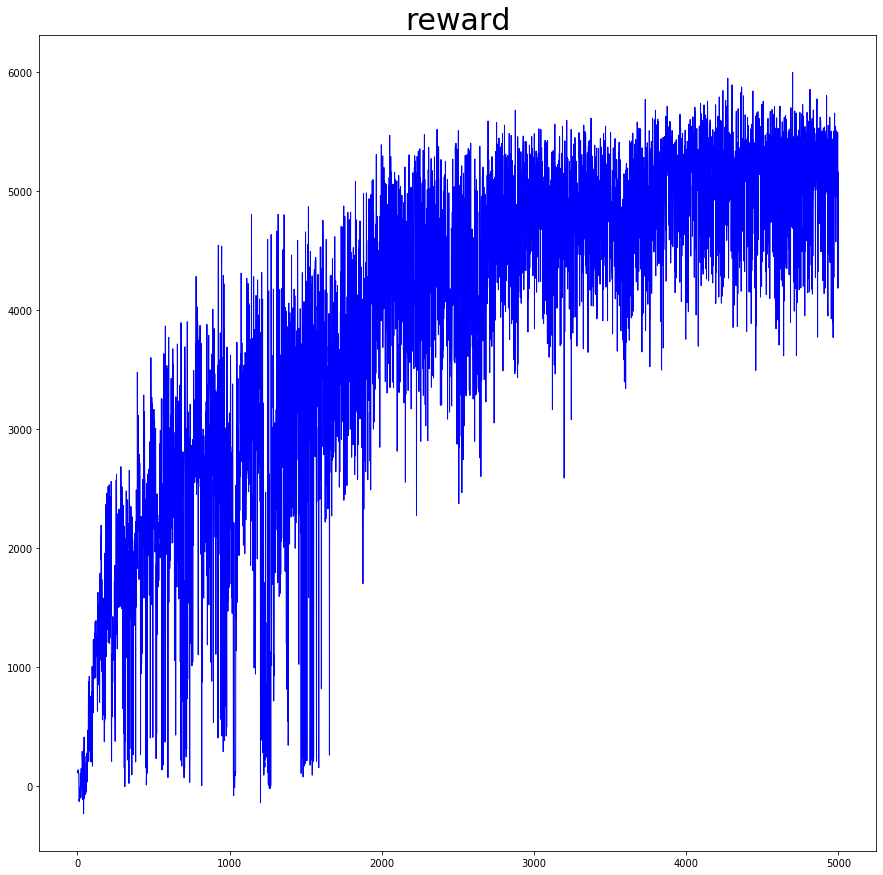

In [7]:
reward_np = np.array(agent.plot_reward[:])
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)

In [11]:
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=True)
observation = env.reset()
state = observation
reward_sum = 0
for t in range(1000):
    agent.set_network_exploration()
    action = agent.get_learning_action([state])
    action = action.squeeze(0)
    obs , reward, done, info = env.step(action.detach().numpy())

    reward_sum += reward
    state = obs[:]
    if(done):
        break
print(reward_sum)
    

5719.088619587966
